# LDATA2010 Exercise Session - Clustering

Clustering aims at automatically discovering groups of similar samples among data sets. This statement briefly introduces different clustering algorithms. The exercises can be realized using the software of your preference (Python, R, Matlab, etc.). The dataset we will use in this session is based on [transcriptomics data](https://en.wikipedia.org/wiki/Transcriptomics_technologies). As you can see when importing the dataset, the first columns are 300 different gene expressions, and the last column ("cell_type") contains an identifier for the type of the cell.

Each row represents the analysis of *one* cell, and each of the "gene" columns contains (in layman's terms and not wholly accurately) the expression of the gene at one location in the sequence.

## Tools and libraries

To help you implement and test the various clustering algorithms presented during this session, we provide a (non-exhaustive) list of libraries that can be useful. Don't hesitate to look at the documentation for each of these libraries, to get a feel of what they can offer you.

In particular, the `pca_decomposition` function implements PCA, a dimensionality reduction method you will see more thoroughly during the course. We will use it now for 2D visualization, because although we might want to test clustering algorithms in 2D, they start being especially useful with high dimensional data.

> Is it better to first reduce the dimensionality of the dataset and then do clustering or first do clustering and then visualize in a lower dimension ?

In [2]:
# Importing the data and nice libraries
import matplotlib.pyplot as plt # https://matplotlib.org/
import numpy as np # https://numpy.org/doc/1.26/user/index.html#user
import pandas as pd # https://pandas.pydata.org/
import seaborn as sns # https://seaborn.pydata.org/
from sklearn.decomposition import PCA # https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
from sklearn.preprocessing import StandardScaler # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from IPython.display import display, clear_output # https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html
from sklearn.datasets import make_circles

def pca_decomposition(df, components=2):
    """Perform PCA on a dataset.

    PCA is a dimensionality reduction method, which we use to go from 300 dimensions down to 2.
    """
    pca = PCA(n_components=components)
    df2 = pca.fit_transform(df)
    return df2, pca

## Dataset
> **Exercise 1**
> Create a scatter plot of X after PCA in a 2-D space. How many clusters do you intuitively observe ? Do you think these clusters are present in the 300-dimension space ?

<div class="alert alert-success" role="alert">


</div>

In [3]:
dataframe = pd.read_csv("https://gist.githubusercontent.com/victorjoos/34b43873616f253451af610ca8460ddf/raw/ad9b89f72c6c67318e08de13871c34d56fbae259/transcriptomics_data.csv")
y = dataframe["cell_type"]
X = dataframe[[col for col in dataframe.columns if col.startswith("gene_")]].to_numpy() # Only keep gene expressions

X_pca, pca = pca_decomposition(X) # Compute PCA DR

print("dataset shape before PCA:", X.shape)
print("dataset shape after PCA:", X_pca.shape)

dataset shape before PCA: (4765, 300)
dataset shape after PCA: (4765, 2)


/var/folders/5d/7ybqtzwx3db6_dlpzqzj7rk40000gn/T/ipykernel_59268/3902776706.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Cell type")


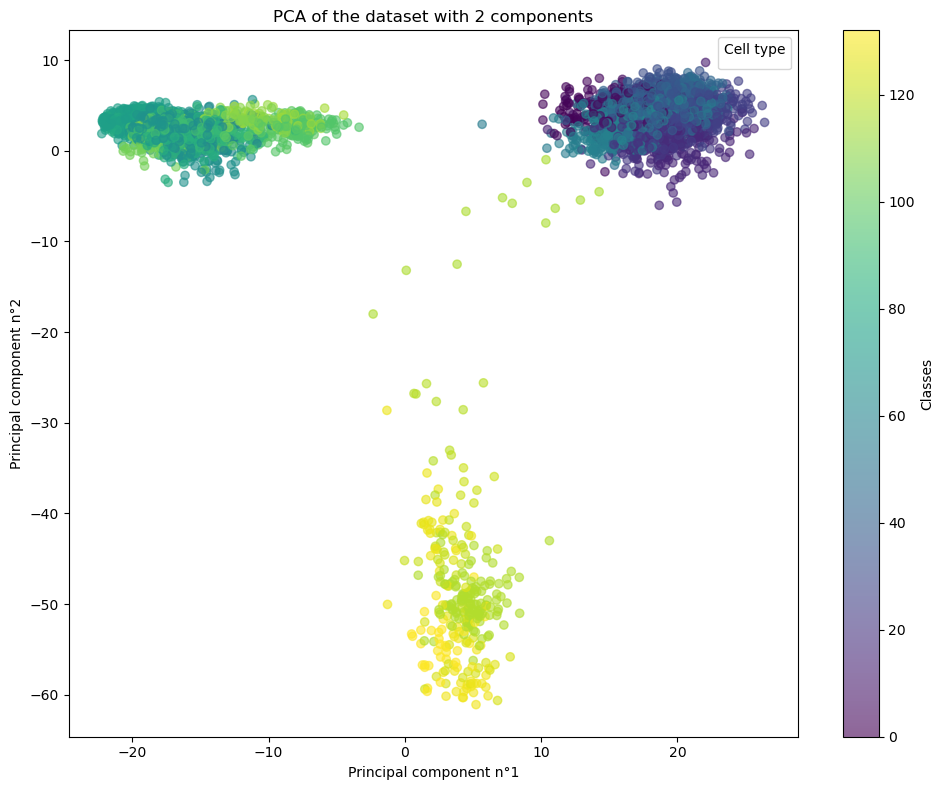

In [4]:
# TODO : plot the PCA results

plt.figure(figsize=(10, 8))

scatter = plt.scatter(x=X_pca[:, 0], y=X_pca[:, 1], c=y, cmap='viridis', alpha=0.6)

plt.colorbar(scatter, label='Classes')
plt.xlabel("Principal component n°1")
plt.ylabel("Principal component n°2")
plt.title("PCA of the dataset with 2 components")

plt.legend(title="Cell type")
plt.tight_layout()
plt.savefig("Figures/PCA_2Components.pdf")
plt.show()

## K-means

The K-means algorithm may be summarized as follows : given,
 - a set $D = \{x_1, ..., x_N\}$ of N data points with dimension H,
 - a distance function d,
 - a number K of clusters,

it defines a set $C = {c_1, ..., c_K}$  of K centroids with dimension H. After initializing the centroids according to some heuristic (e.g. randomly in the data space, randomly in D, etc.), the centroid coordinates are updated according to the following scheme:

 1. For each $i \in \{1, ..., K\}$, compute $D_i = \{x_j \in D | i = \mathrm{argmin}_{l\in{1, ..., K}} d(c_l, x_j)\}$
 2. For each $i \in \{1, ..., K\}$, set $c_i \leftarrow \frac{1}{ | D_i | } \sum_{x\in D_i}{x}$

Computing steps 1 and 2 corresponds to performing *one* iteration. Iterations are repeated until convergence of the centroids or after a maximum number has been reached. The clusters are then defined as the sets $D_i$ for $i\in\{1, ..., K\}$

> **Exercise 2** Implement the K-means algorithm with Euclidian distance and apply it to X with K = 3 clusters and with the centroids chosen at random from the dataset. After each iteration, show the new clusters and centroids. How many iterations are needed before convergence ? Does the result seem intuitive ?
>
> What happens when you change K ?
>
> Do all the cells with the same cell type go in the same cluster ? How would you visualize this ?
>
> Does K-Means work even when the initial centroids are all in the same cluster ?
>
> Do you get the same result when doing the clustering on `X_pca` ?

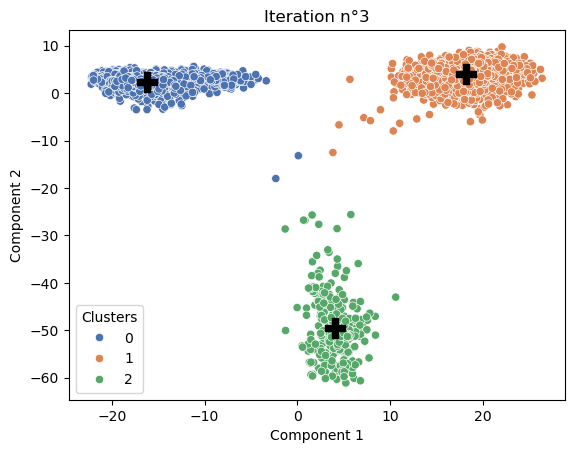

In [31]:
import time
fig, ax = plt.subplots(1)

def initialize_centroids(X, K, method='random'):
    """Randomly select K initial centroids from the dataset or use K-means++."""

    if K > len(X):
        raise ValueError("K cannot be greater than the number of samples in the dataset.")

    if method == 'random':
        initial_indices = np.random.choice(len(X), size=K, replace=False)
        return X[initial_indices]
    
    elif method == 'kmeans++':
        centroids = [X[np.random.choice(len(X))]]
        
        for _ in range(1, K):
            distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
            min_distances = np.min(distances, axis=1)

            probabilities = min_distances ** 2  
            probabilities /= probabilities.sum()
            
            next_centroid = X[np.random.choice(len(X), p=probabilities)]
            centroids.append(next_centroid)
            
        return np.array(centroids)
    else:
        raise ValueError("Unknown method. Choose either 'random' or 'kmeans++'.")

def visualize_kmeans_iteration(X_pca, clusters, centroids, iteration, delay=0.5):
    """Visualize the current state of the K-means algorithm."""

    ax.cla()
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette="deep", ax=ax, legend='full')
    C_pca = pca.transform(centroids)
    ax.scatter(C_pca[:, 0], C_pca[:, 1], c="black", marker="P", s=200)  # Centroids
    ax.set_title(f'Iteration n°{iteration}')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    plt.legend(title='Clusters')
    display(fig)
    time.sleep(delay)
    clear_output(wait=True)

def kmeans_iteration(X, centroids):
    """Perform one iteration of the k-means algorithm."""

    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    clusters = np.argmin(distances, axis=1)
    centroids = np.array([X[clusters == k].mean(axis=0) for k in range(len(centroids))])
    return clusters, centroids

def kmeans(X, K=3, max_iter=10, init_method='random', visualize=True):
    """Run the K-means algorithm and optionally visualize the results."""

    centroids = initialize_centroids(X, K, method=init_method)

    for i in range(1, max_iter + 1):

        clusters, new_centroids = kmeans_iteration(X, centroids)
        if np.allclose(centroids, new_centroids): break
        centroids = new_centroids
        if visualize: visualize_kmeans_iteration(X_pca, clusters, centroids, i)

    return clusters, centroids, i

clusters, final_centroids, iterations = kmeans(X, K=3, max_iter=20, init_method='random', visualize=True)

In [37]:
import numpy as np
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
)

def calculate_clustering_metrics(X, labels, true_labels=None):
    """
    Calculate various clustering metrics.
    
    Parameters:
    - X: array-like, shape (n_samples, n_features)
        The input data.
    - labels: array-like, shape (n_samples,)
        The cluster labels assigned by the clustering algorithm.
    - true_labels: array-like, shape (n_samples,), optional
        The true labels for the data, used to calculate ARI and NMI.
    
    Returns:
    - metrics: dict
        A dictionary containing various clustering metrics.
    """
    metrics = {}

    # Calculate silhouette score (maximize)
    metrics['Silhouette Score'] = silhouette_score(X, labels)
    
    # Calculate Davies-Bouldin index (minimize)
    metrics['Davies-Bouldin Index'] = davies_bouldin_score(X, labels)
    
    # Calculate Calinski-Harabasz index (maximize)
    metrics['Calinski-Harabasz Index'] = calinski_harabasz_score(X, labels)
    
    # Calculate WCSS (minimize)
    unique_labels = np.unique(labels)
    wcss = sum(np.sum((X[labels == k] - np.mean(X[labels == k], axis=0)) ** 2) for k in unique_labels)
    metrics['WCSS'] = wcss
    
    # Calculate Separation vs. Compactness Ratio
    cluster_centroids = np.array([X[labels == k].mean(axis=0) for k in unique_labels])
    
    # Compactness: Average distance of points to their centroids
    compactness = np.mean([np.mean(np.linalg.norm(X[labels == k] - cluster_centroids[i], axis=1)) for i, k in enumerate(unique_labels)])
    
    # Separation: Average distance between centroids
    separation = np.mean([np.linalg.norm(cluster_centroids[i] - cluster_centroids[j]) for i in range(len(cluster_centroids)) for j in range(i + 1, len(cluster_centroids))])
    
    # Avoid division by zero
    if separation != 0:
        metrics['Separation/Compactness Ratio'] = separation / compactness
    else:
        metrics['Separation/Compactness Ratio'] = np.inf  # or set to some maximum value
    
    # Calculate Adjusted Rand Index and Normalized Mutual Information if true labels are provided
    if true_labels is not None:
        from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
        metrics['Adjusted Rand Index'] = adjusted_rand_score(true_labels, labels)
        metrics['Normalized Mutual Information'] = normalized_mutual_info_score(true_labels, labels)
    
    return metrics

# Example of usage:
# Assuming you have your data `X`, cluster labels `clusters`, and optional true labels `true_labels`.
# metrics = calculate_clustering_metrics(X, clusters, true_labels)
# print(metrics)



for k in [2, 4, 8, 16, 32]:
    clusters, final_centroids, iterations = kmeans(X, K=k, max_iter=100, init_method='random', visualize=False)
    print(f"K={k}, Iterations: {iterations}")
    metrics = calculate_clustering_metrics(X, clusters)
    print(metrics)

K=2, Iterations: 4
{'Silhouette Score': 0.3298058677225746, 'Davies-Bouldin Index': 1.409821965190693, 'Calinski-Harabasz Index': 1803.2771757259377, 'WCSS': 3447503.6276038345, 'Separation/Compactness Ratio': 1.4186188393862051}
K=4, Iterations: 7
{'Silhouette Score': 0.37345579683346036, 'Davies-Bouldin Index': 1.4243672721911764, 'Calinski-Harabasz Index': 1610.0380098144942, 'WCSS': 2359241.986793101, 'Separation/Compactness Ratio': 1.6800739456693154}
K=8, Iterations: 11
{'Silhouette Score': 0.18640817891492198, 'Davies-Bouldin Index': 1.723960205927749, 'Calinski-Harabasz Index': 789.0741894061098, 'WCSS': 2199183.452919773, 'Separation/Compactness Ratio': 2.16363751762456}
K=16, Iterations: 18
{'Silhouette Score': 0.2050988124682711, 'Davies-Bouldin Index': 1.6311211558530152, 'Calinski-Harabasz Index': 568.8005062751291, 'WCSS': 1699473.92693762, 'Separation/Compactness Ratio': 2.5492336943434077}
K=32, Iterations: 18
{'Silhouette Score': 0.1802191338583489, 'Davies-Bouldin Ind

## Nearest neighbor clustering
Given a set $D = \{x_1, ..., x_N\}$ of $N$ data points, a distance function $d$ and a threshold $t$, nearest neighbor clustering defines clusters in $D$ in the following way :

 - Define $C_1 = \{x_1\}, C= \{C_1\}$ and $K = 1$;
 - For $i = 2,..., N$,
  1. Compute $j = \mathrm{argmin}_{l\in\{1,...,i-1\}}d(x_l,x_i)$
  2. If $d(x_j, x_i) \ge t$ set $K\leftarrow K + 1$, define $C_K = {x_i}$ and set $C \leftarrow C \cup \{C_K\}$
  3. Otherwise, identify $k\in {1, ..., K}$ such that $x_j \in C_k$ and set $C_k \leftarrow C_k \cup \{x_i\}$

Whereas K-means needs the user to specify the desired number K of clusters, nearest neighbor clustering instead requires to define a threshold $t$ for the minimum distance between two clusters.

> **Exercise 3** Implement nearest neighor clustering with the Euclidian distance and apply it to X, using a threshold t = 5. Do you obtain the same result as when using K-means ? Does the order of the dataset matter ?
>
> How does the algorithm change when using a different threshold ? What is the threshold range where you get 3 clusters ?

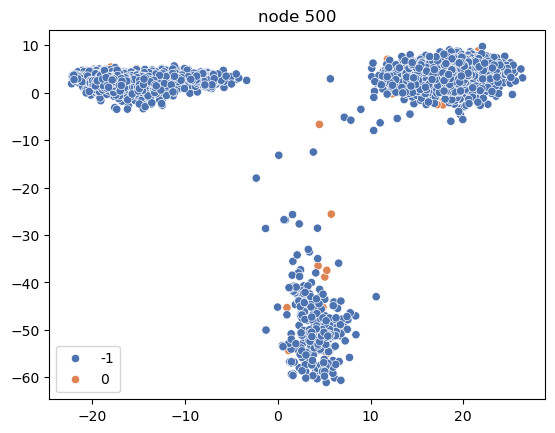

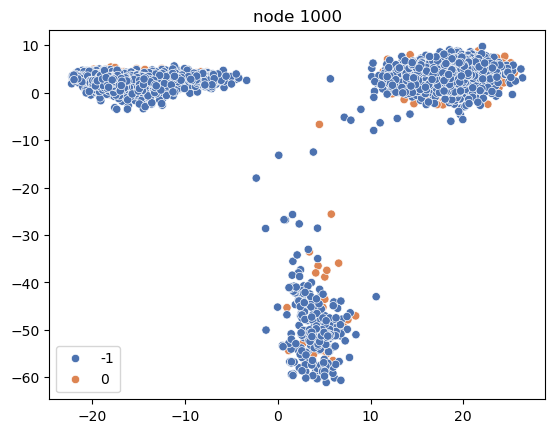

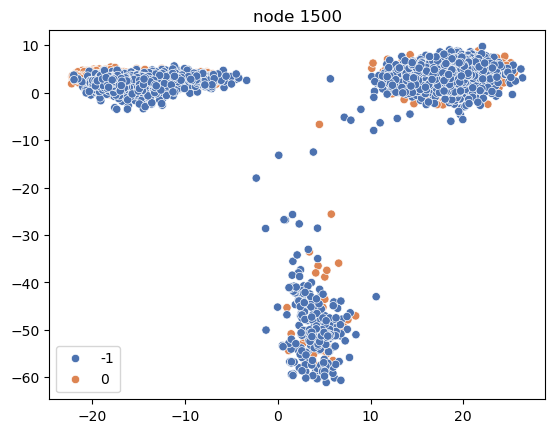

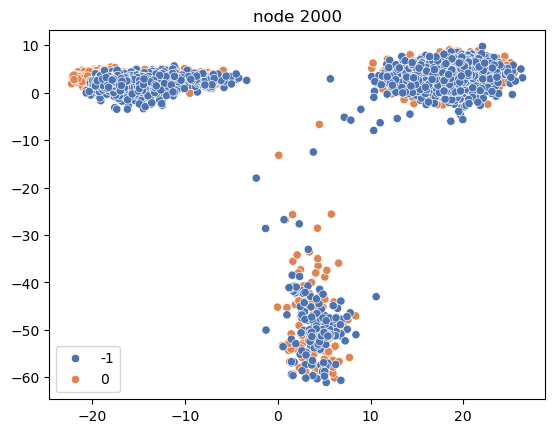

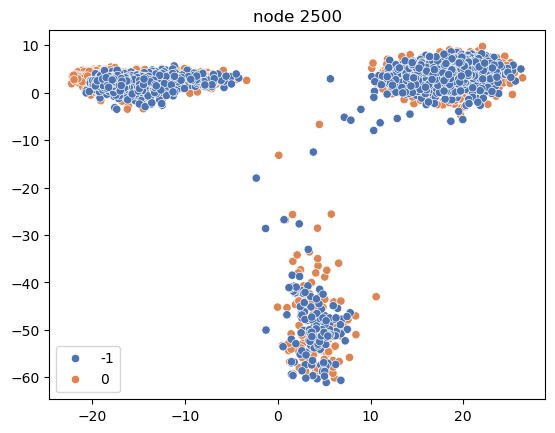

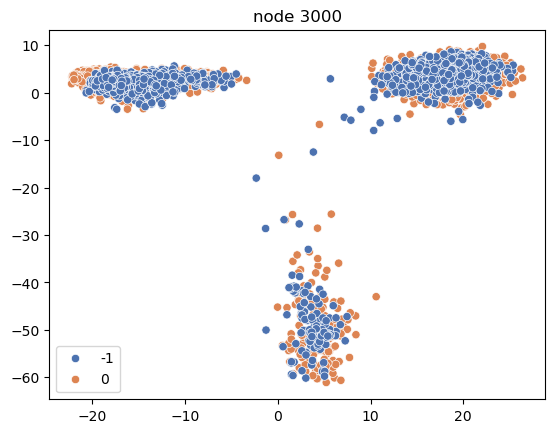

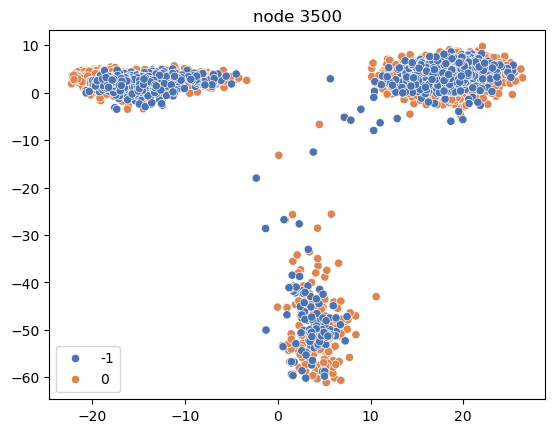

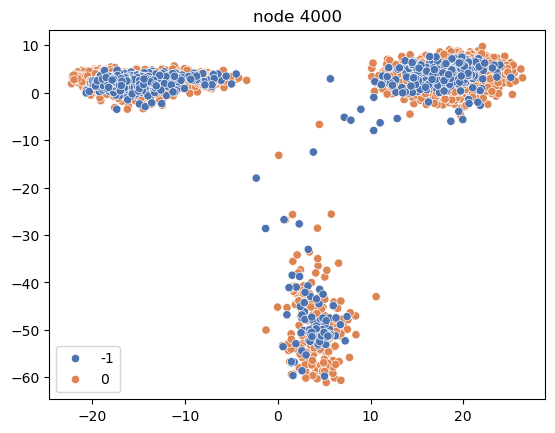

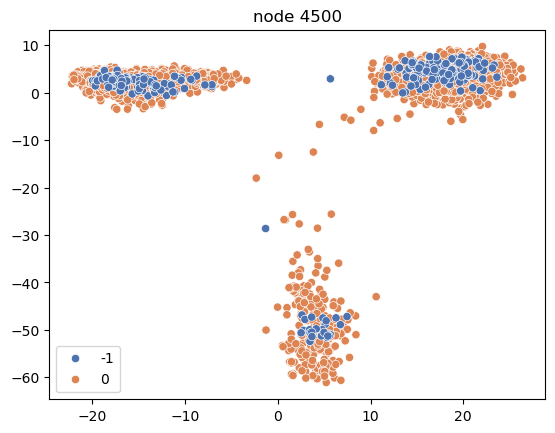

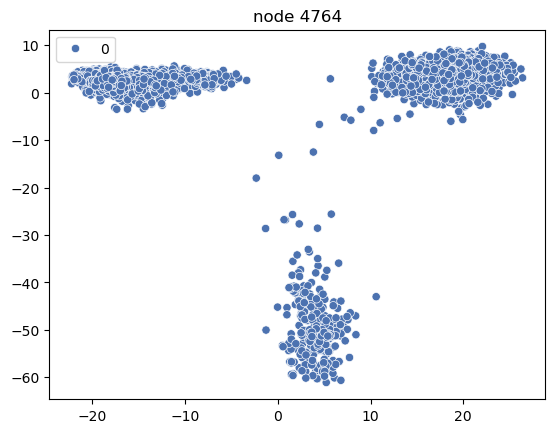

In [6]:
def nneighbor_iteration(X, i, clusters, threshold):
    # 1. compute the index of the closest neighbor
    j = i-1 # CHANGME
    # 2. update the clusters
    clusters[i] = clusters[j] # CHANGME : take care of the threshold
    return clusters

threshold = 50 # CHANGME ?
clusters = np.ones(len(X), dtype=int) * -1 # init all nodes to to a negative index ("unassigned")
clusters[0] = 0 # create the first cluster

##  Visualization
display_every_n = 500 # CHANGME ?


for i in range(1, len(X)):
    clusters = nneighbor_iteration(X, i, clusters, threshold)
    if (i % display_every_n) == 0 or i == len(X)-1:
      fig, ax = plt.subplots(1)
      sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters[:], palette="deep", ax=ax)
      ax.set_title(f"node {i}")
      # Alternative, to display only assigned nodes :
      # sns.scatterplot(x=X_pca[:i,0], y=X_pca[:i,1], hue=clusters[:i], palette="deep", ax=ax)
      plt.show()

##  DBSCAN

DBSCAN, for "Density-Based Spatial Clustering of Applications with Noise" allows the unsupervised clustering of data points by defining clusters as groups of points of high density separated by zones of low point density. Taking into account the density of data points allows the algorithm to be more robust to outliers, and to identify clusters of more diverse shapes than K-means. More information can be found on [scikit-learn description](https://scikit-learn.org/stable/modules/clustering.html#dbscan), [wikipedia article](https://en.wikipedia.org/wiki/DBSCAN#:~:text=Density%2Dbased%20spatial%20clustering%20of,and%20Xiaowei%20Xu%20in%201996.) and [more detailed publication](https://www.khoury.northeastern.edu/home/vip/teach/DMcourse/2_cluster_EM_mixt/notes_slides/revisitofrevisitDBSCAN.pdf).


DBSCAN does not require the user to set a number $K$ of clusters. Instead, the algorithm relies on $ϵ$, the radius of the hypersphere around each point used to determine if other points are linked to it, and $min\_samples$, the minimum number of neighbours in the hypersphere for a point to be considered a core sample (see links above).

> **Exercise 4** Complete the code below to visualise the 2-dimensional circle dataset using the true labels, labels determined by KMeans (use $K=4$ for this dataset), and labels obtained with [scikit-learn's implementation of the DBSCAN algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN).
>
> 1. Load the 2D circles and observe the data using the true labels in a 2D scatterplot (use the plot_with_labels(X, Y) function).
> 2. Apply k-means on it, using $K=4$. Observe the results. Does the assigned clusters make sense considering the data set?
> 3. After reading about the DBSCAN algorithm, why could one expect it to be more appropriate that an isotropic prototype-based algorithm such as K-means, on this data set?
> 4. Apply the DBSCAN algorithm on the data set using the default hyperparameters proposed by sci-kit learn. Are the results the expected results?
> 5. Fix $min\_samples=4$, and try multiple hyperparameter values for $ϵ$, how do the results change? Can you build intuition on how the number of found clusters changes with changes in $ϵ$ values?
> 6. Think of protocols or heuristics that could help find an appropriate value for $ϵ$. Try them with some code.

In [7]:
# 2D plot of the data
def plot_with_labels(X, Y):
  N, M = X.shape
  X2d = X
  if M < 2:
    print("too low dimensionality")
    return
  elif M > 2:
    X2d = PCA(n_components=2).fit_transform(X)
  plt.scatter(X2d[:, 0], X2d[:, 1], c = Y)

# returns the number of unique values in the 1D numpy array Y
# can be useful in order to determine the number of clusters that were found by a clustering algorithm
def N_unique_values(Y):
  return np.unique(Y).shape[0]

# building the dataset
circles_1, true_labels_1 = make_circles(n_samples = 1000, noise = 0.02, factor=0.75)
circles_2, true_labels_2 = make_circles(n_samples = 500, noise = 0.04, factor=0.5)
circles     = np.vstack((circles_1*1.2, circles_2 * 0.6))
true_labels = np.hstack((true_labels_1, true_labels_2+2))

In [8]:
# show the dataset using the true labels
# plot_with_labels(circles, true_labels)

# Your code here !

In [9]:
# apply K-means on the circles dataset and visualise the results
# With your own implementation of K-means or
# from sklearn.cluster import KMeans

# Your code here !

In [10]:
# apply the DBSCAN algorithm on the circles dataset and visualise the results. Try using different hyperparameter values
from sklearn.cluster import DBSCAN # https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

# Your code here !


## Agglomerative hierarchical clustering

Given a data set and some distance function $d$, agglomerative hierarchical clustering initially considers every example as a cluster of its own. Then at each iteration, the two closest clusters are merged. The algorithm terminates as soon as there is only a single cluster remaining, containing the whole data set. In order to determine the two closest clusters at each iteration, the distance between two clusters $C_1$ and $C_2$ is defined as:

- $min_{x∈C_1,y∈C_2}d(x, y)$ in single link agglomerative clustering
- $max_{x∈C_1,y∈C_2}d(x, y)$ in complete-link agglomerative clustering
- $\frac{1}{\vert C_1\vert.\vert C_2\vert}∑_{x∈C_1,y∈C_2}d(x, y)$ in average-link agglomerative clustering
-$d(\frac{∑_{x∈C_1}x}{\vert C_1\vert}, \frac{∑_{x∈C_2}x}{\vert C_2\vert})$ in centroid agglomerative clustering

When applying agglomerative clustering, a hierarchy of clusters is defined and can be represented through a [dendrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html).


> **Exercise 5** Implement the algorithm, with the four variants. Apply it on the `data_2d` data set and visualise the hierarchy using a dendrogram. Does the results differ from one variant to another?
>
> What is the time complexity of the algorithm? Compare the computation time when applying it to the `data_2d` data set and `X`, the data set from exercice 1. If a hierarchy of clusters was desired on a large, real-world data set, how would you mitigate the effect of the high temporal complexity of this algorithm?


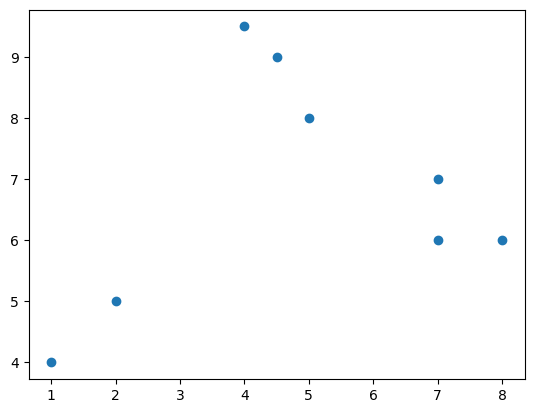

In [11]:
data_2d = np.array([[4., 9.5], [2., 5.], [8., 6.], [5., 8.], [7., 7.], [7., 6.], [1., 4.], [4.5, 9.]])
plt.scatter(data_2d[:, 0], data_2d[:, 1])

In [12]:
# Your code here !